In [1]:
import logging
import sys
from pathlib import Path
import itertools

import click
import numpy as np
import pandas as pd
import rasterra as rt
from rra_tools import jobmon
from scipy.special import expit
import xarray as xr
import tqdm
import rasterra as rt
from rasterio.features import rasterize
import geopandas as gpd

from spatial_temp_cgf import paths
from spatial_temp_cgf.training_data_prep import income_funcs
from spatial_temp_cgf.training_data_prep.location_mapping import load_fhs_lsae_mapping
from spatial_temp_cgf import cli_options as clio
from spatial_temp_cgf.data import DEFAULT_ROOT, ClimateMalnutritionData

In [2]:
RASTER_TEMPLATE_PATH = Path('/mnt/team/rapidresponse/pub/population/data/01-raw-data/other-gridded-pop-projects/global-human-settlement-layer/1km_template.tif')
SHAPE_PATH = Path('/mnt/team/rapidresponse/pub/population/data/02-processed-data/ihme/lbd_admin2.parquet')
LDIPC_FILEPATH = Path('/share/resource_tracking/forecasting/poverty/GK_2024_income_distribution_forecasts/income_forecasting_through2100_admin2_final_nocoviddummy_intshift/admin2_ldipc_estimates.csv')

In [3]:
raster_template = rt.load_raster(RASTER_TEMPLATE_PATH)

In [4]:
a2 = gpd.read_parquet(SHAPE_PATH)

In [5]:
ldi = pd.read_csv(LDIPC_FILEPATH)
national_mean = ldi.groupby(['year_id', 'national_ihme_loc_id', 'population_percentile']).ldipc.transform('mean')
null_mask = ldi.ldipc.isnull()
ldi.loc[null_mask, 'ldipc'] = national_mean.loc[null_mask]
ldi['ldi_pc_pd'] = ldi['ldipc'] / 365.25
ldi = ldi.groupby(['year_id', 'location_id']).ldi_pc_pd.mean().reset_index()

In [6]:
polys = a2.loc[a2.loc_id.isin(ldi.location_id.unique()), ['loc_id', 'geometry']].rename(columns={'loc_id': 'location_id'}).set_index('location_id').geometry

In [ ]:
for year in [2000, 2001]:
    year_ldi = ldi[ldi.year_id == 2000].set_index('location_id').ldi_pc_pd
    

In [12]:
year_ldi = ldi[ldi.year_id == 2000].set_index('location_id').ldi_pc_pd
shapes = [(t.geometry, t.ldi_pc_pd) for t in pd.concat([year_ldi, polys.sort_index()], axis=1).itertuples()]
arr = rasterize(
    shapes, 
    out=np.zeros_like(raster_template), 
    transform=raster_template.transform, 
)


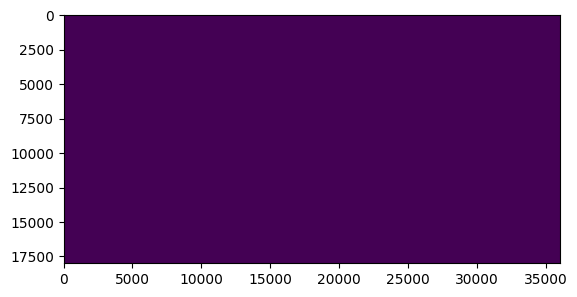

In [13]:
import matplotlib.pyplot as plt
plt.imshow(np.isnan(arr))

In [15]:
r = rt.RasterArray(arr, transform=raster_template.transform, crs=raster_template.crs, no_data_value=np.nan)

Text(0.5, 1.0, 'LDI per capita per day 2000')

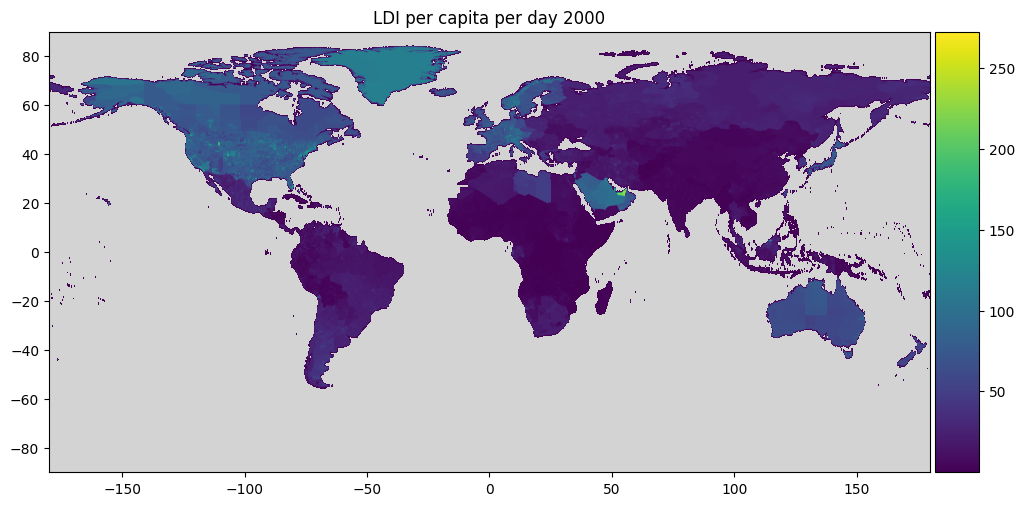

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
r.plot(ax=ax, vmin=0.001, under_color='lightgrey')
ax.set_title('LDI per capita per day 2000')

In [ ]:
# missing_ldi = set(a2.loc_id).difference(ldi.location_id)
# missing_shape = set(ldi.location_id).difference(a2.loc_id)
# a2[a2.loc_id.isin(missing_ldi)].ADM0_NAME.unique()

In [ ]:
means = df[df.population_percentile > 0].groupby(['year_id', 'location_id', 'ihme_loc_id']).ldipc.mean().reset_index()
means['ldipc'] /= 365.25

In [ ]:
bottom_8 = means[means.year_id == 2100].sort_values('ldipc').ihme_loc_id[:8]
top_8 = means[means.year_id == 2100].sort_values('ldipc').ihme_loc_id[-8:]
now_top_8 = means[means.year_id == 2024].sort_values('ldipc').ihme_loc_id[-8:]

In [ ]:
import seaborn as sns


sns.lineplot(data=means[means.ihme_loc_id.isin(now_top_8)], x='year_id', y='ldipc', hue='ihme_loc_id')

In [ ]:
sns.lineplot(data=means[means.ihme_loc_id.isin(top_8)], x='year_id', y='ldipc', hue='ihme_loc_id')